# using logistic regression and knn to predict credit card fraud

In [36]:
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 1000)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.api import add_constant

from statsmodels.regression.linear_model import RegressionResults
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
# Note --  Requires sklearn version .18 or higher  

from sklearn.metrics import r2_score
from collections import Counter
sns.set(style="ticks")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

assert(sys.version_info.major==3),print(sys.version)
# Python 3 or higher is required

## Part (1): Load in the Cancer data and conduct basic EDA

In [37]:
df = pd.read_csv("creditcard.csv")

In [38]:
# show top 5 lines by default
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [39]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 1. Normalize the data


In [40]:
def normalize(x):
    num = x - np.min(x)
    denom = np.max(x) - np.min(x)
    return (num / denom)

df.iloc[:, 0:30] = normalize(df.iloc[:, 0:30])

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


## 2. Split the data

In [41]:
def split_data(data, train_size=.7):
    # creat a list of the indexes of fraud&nonfraud behaviour data
    index1 = data[data['Class']==1].index.values
    index0 = data[data['Class']==0].index.values
    # Determine the number of observations we have in each data set:
    length1 = len(index1)
    length0 = len(index0)
    
    # Use numpy's random.shuffle() function to randomly shuffle over our index:
    np.random.shuffle(index1)
    np.random.shuffle(index0)
    
    # Create a list for the first 70% of the shuffled indices and set to training: 
    train_indices1 = index1[0:int(length1 * train_size)]
    train_indices0 = index0[0:int(length0 * train_size)]
    train_indices = np.append(train_indices1, train_indices0, axis = 0)
    
    # Create a list for the remaining 30% of the shuffled indices and set to testing:
    test_indices1 = index1[int(length1 * train_size):]
    test_indices0 = index0[int(length0 * train_size):]
    test_indices = np.append(test_indices1,test_indices0, axis = 0)
    
    # Use the list of training indices to find the corresponding data entries:
    train = data.iloc[train_indices]
    # Use the list of testing indices to find the corresponding data entries:
    test = data.iloc[test_indices]
    
    # Return two dataframes, one with the testing data and one with the training data:
    return train, test

use the function to split the actual data

In [42]:
df_train,df_test  = split_data(df)
df_train.shape

(199364, 31)

In [79]:

X_train = df_train.loc[:, df_train.columns != 'Class'] #Your code goes here
X_test  = df_test.loc[:, df_test.columns != 'Class']

X_train_np = X_train.values # This is to create a numpy array version of the training and testing set.
X_test_np  = X_test.values
y_train = df_train['Class'].values
y_test = df_test['Class'].values


## 3.  Using one single predictor to fit a Linear Regression Model

We will use the training/testing dataset as before and create our logistic regression objects.

Let's use one single predictor variable, `V 10` and fit a linear regression model to it. 

In [80]:
import statsmodels.api as sm
X_train_V_10 = sm.add_constant(X_train["V10"])
X_test_V_10 = sm.add_constant(X_test["V10"])

ols = OLS(endog=y_train, exog=X_train_V_10).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     9715.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:32:54   Log-Likelihood:             3.5623e+05
No. Observations:              199364   AIC:                        -7.125e+05
Df Residuals:                  199362   BIC:                        -7.124e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2040      0.002     99.309      0.000       0.200       0.208
V10           -0.3976      0.004    -98.566      0.000      -0.406      -0.390
==============================================================================
Omnibus:                   455375.505   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2328850286.992
Skew:                          22.492   Prob(JB):                         0.00
Kurtosis:                     530.570   Cond. No.                         56.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Let’s plot our model… 

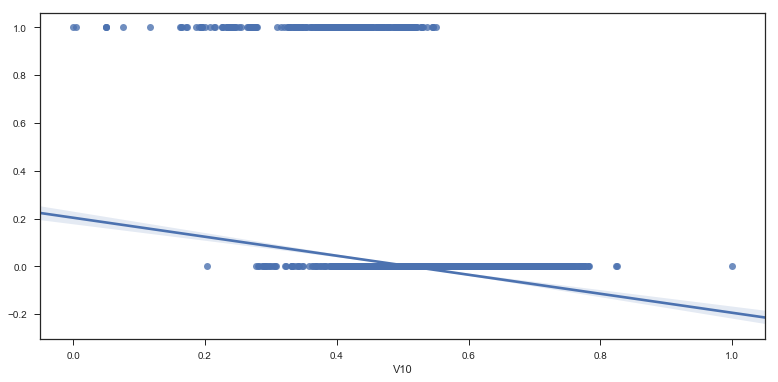

In [81]:
sns.regplot(x=X_train["V10"], y=y_train)

In [82]:
y_hat_train = ols.predict(X_train_V_10)
y_hat_test = ols.predict(X_test_V_10)
y_hat_test

91671     0.002482
52584     0.024402
177195    0.024575
6899      0.060896
8296      0.107374
192529    0.047548
89190     0.034561
221041    0.027033
42674     0.097080
281674    0.009042
150601    0.113126
6641      0.034180
68067     0.002965
142405    0.073684
150644    0.100547
151008    0.184266
6609      0.052737
144754    0.018759
31002     0.063451
154718    0.062071
178208    0.041970
191544    0.033871
83053     0.028359
76929     0.050886
154670    0.075723
124176    0.020086
9252      0.109807
42936     0.106181
144104    0.051057
8615      0.110274
203324    0.020418
208651    0.044346
249167    0.038271
18466     0.017237
154633    0.037626
213092   -0.031437
141259    0.070325
11343     0.111548
20198    -0.024968
143335    0.071971
244004    0.020859
204503    0.033331
223618    0.037937
234574    0.053441
10568     0.097388
15736     0.071185
197586    0.020226
255556    0.034336
63421     0.053119
244333    0.020151
623       0.008629
18773     0.039512
226877    0.

Notice it is possible for us to convert the above values into a binary classification by the following code.

In [83]:
y_hat_train_0_1 = y_hat_train >.5
y_hat_test_0_1 = y_hat_test >.5

print("Training Set Accuracy for Linear Regression: ", accuracy_score(y_train, y_hat_train_0_1))
print("Test Set Accuracy for Linear Regression: ", accuracy_score(y_test, y_hat_test_0_1))

Training Set Accuracy for Linear Regression:  0.9982745129511847
Test Set Accuracy for Linear Regression:  0.9982678510820079


## 4. Using one single predictor to fit a Logistic Regression Model instead

Now we can instead fit a logistic regression model onto our data and see how things change.

In [84]:
logistic_mod = LogisticRegression(C=100, fit_intercept=True) #The C value here is a way to prevent regularization
X_train_mul_wcons = sm.add_constant(X_train["V10"])
X_test_mul_wcons = sm.add_constant(X_test["V10"])
logistic_mod.fit(X_train_mul_wcons, y_train)

y_hat_train_logistic_mod = logistic_mod.predict(X_train_mul_wcons)
y_hat_test_logistic_mod = logistic_mod.predict(X_test_mul_wcons)

print("Training Accuracy for Logistic Regression: ", accuracy_score(y_train, y_hat_train_logistic_mod))
print("Test Accuracy for Logistic Regression: ", accuracy_score(y_test, y_hat_test_logistic_mod))

Training Accuracy for Logistic Regression:  0.9986707730583255
Test Accuracy for Logistic Regression:  0.9987125920204113


## 5. Using all predictor variables in a logistic regression

In [110]:
logistic_mod_all = LogisticRegression(C=100000, fit_intercept=True)
X_train_mul_wcons = sm.add_constant(X_train)
X_test_mul_wcons = sm.add_constant(X_test)

lrmodel = logistic_mod_all.fit(X_train_mul_wcons, y_train)
y_hat_train_logistic_mod_all = logistic_mod_all.predict(X_train_mul_wcons)
y_hat_test_logistic_mod_all = logistic_mod_all.predict(X_test_mul_wcons)
print("Training accuracy for Logistic Regression: ", accuracy_score(y_train, y_hat_train_logistic_mod_all))
print("Test accuracy for Logistic Regression: ", accuracy_score(y_test, y_hat_test_logistic_mod_all))

Training accuracy for Logistic Regression:  0.9991773840813788
Test accuracy for Logistic Regression:  0.9992860737567735


## Question Do we have binary logistic regression summary?

In [112]:
from pyspark.ml.classification import LogisticRegression
lrmodelsummary = lrmodel.summary

ModuleNotFoundError: No module named 'pyspark'

In [86]:
# evaluate the accuracy measures
predicted = np.round(y_hat_test_logistic_mod_all)
expected = y_test
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.88      0.68      0.77       148

avg / total       1.00      1.00      1.00     85443



In [87]:
# check the confusion matrix
pd.crosstab(expected,predicted,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,All
Actual,,,
0,85282,13,85295
1,48,100,148
All,85330,113,85443


## 6. Incorporating Bootstrapping in a Logistic Regression Model

The main idea behind bootstrapping is to resample our data many times. For EACH time that we resample our data, we will fit the Logistic Regression model. Then for EACH resampling, we can find an associated confidence interval. 

Compared to traditional statistical confidence intervals, the bootstrap confidence intervals are free from empirical assumptions of the data.

### The code below helps us conduct a boostrap analysis and be able to obtain confidence interval estimates for each coefficient value!

In [90]:
B = 100 # Number of iterations

boot_coefs = np.zeros((X_train.shape[1]+1,B)) # Create empty storage array for later use

for i in range(B):
    # Sampling WITH replacement the indices of a resampled dataset
    sample_index = np.random.choice(range(len(y_train)), size=len(y_train), replace=True)
    X_train_samples = X_train_mul_wcons.values[sample_index]
    y_train_samples = y_train[sample_index]
    
    logistic_mod_boot = LogisticRegression(C=100000, fit_intercept=True)
    logistic_mod_boot.fit(X_train_samples, y_train_samples)
    boot_coefs[:,i] = logistic_mod_boot.coef_

boot_coefs.shape

(31, 100)

In [95]:
boot_coefs

array([[ 18.61768439,  29.07024297,  29.53531299, ...,  42.61517494,
         33.4880086 ,  29.29267811],
       [  0.06474918,  -1.10034889,  -0.22672553, ...,  -0.64244893,
         -1.1555187 ,  -0.55595314],
       [  1.73580931,   9.18719898,   3.90356464, ...,  12.0651244 ,
          8.65893011,   8.77648258],
       ...,
       [-39.81683201, -27.11433762, -46.35517502, ..., -48.66330954,
        -52.73381479, -55.78308062],
       [-17.67739219,  -9.09128379, -14.79207115, ..., -14.26817175,
        -20.56993134, -18.15449215],
       [ 27.25056406,  21.62667975,  18.65260629, ...,  21.99526853,
         38.7380758 ,  33.50793904]])

In [99]:
boot_coefs[1]

array([ 0.06474918, -1.10034889, -0.22672553, -0.70337602, -0.21806237,
       -0.33078374, -0.7808378 , -0.46293902, -1.17205486, -0.51089218,
       -0.45280299, -0.75357909, -0.73685097, -0.63086796, -0.69742575,
       -0.3871633 , -0.51623636, -0.53762426, -0.40771114, -0.74094441,
        0.09727066, -1.08273886, -0.42177591, -1.05557308,  0.55345043,
       -1.37072168, -0.26797117, -1.04370959, -0.80787525, -0.13862455,
       -0.34577687, -0.93749337, -1.24934046, -1.10914169, -0.16425098,
       -1.00080665, -0.19484969, -0.01521422, -0.57768405,  0.0565753 ,
       -0.73441608, -1.21788332, -0.60072617, -1.43352403, -0.47343425,
       -0.40022692, -0.04437486, -1.01829091, -0.98148098, -0.38153194,
       -1.36730381, -1.38745962, -0.36237083, -1.16451913, -1.11920764,
       -1.23264159, -0.9812173 , -1.03941642, -1.28744566, -0.79144466,
        0.39290682, -0.94322668,  0.06237527, -0.66576866, -0.38104219,
       -0.21173388, -1.09487787, -0.44833506, -0.49925673, -1.19

In [100]:
boot_coefs[3]

array([  9.70093008,  -3.36585778,   3.06631091, -10.32614405,
        10.45973019,   0.74835871,   2.76777039,  11.62864942,
         2.78912549,   5.8325713 ,   9.93492254,  23.99151973,
        -5.81985628,  -2.62176475,   9.86172368,   4.38428385,
         1.17468701,   5.98662273,   3.40872753,  -2.81559142,
        22.27304685,   0.14858675,  21.47941847,  -1.95506645,
        -6.11326296,  -2.10648181,   2.25002587,  -1.5835139 ,
        -0.42590208,   3.17621516,   5.78191192,   3.64784796,
         7.06213005,  -2.27504592,  33.34970052,  -0.86636713,
        12.58303921,  18.39074944,   9.32554777,  -4.67820183,
         6.98893836,   4.54799744,  -8.78420336,  -5.92234284,
         2.55752999,   5.54713806,  12.36209561,   7.70946781,
        -9.52909754,  -5.83535503,  -1.68564612,   0.12877172,
         0.44180568,   5.12561963,   6.68904807,   2.85480313,
        27.94824223,  -0.4750544 ,   3.2135067 ,  14.45879192,
        -6.62194107,  -0.04415321,  15.48056836,  16.68

In [102]:
boot_coefs[2]

array([ 1.73580931,  9.18719898,  3.90356464,  9.76443162,  5.50317364,
        7.56248925,  5.53713637,  8.43775569,  6.36401038,  7.06163472,
        0.73873853,  9.39952843, 12.98553957,  3.12390998,  6.04041966,
        7.05668969,  8.81127269,  5.76058255,  7.00296524,  5.50567711,
        0.20603141,  7.39352189,  2.85966288, 13.39908218,  8.31718771,
       12.78744931,  8.69620639,  8.26626146, 13.26969523,  3.52419162,
        5.89436583,  9.08262673, 11.54186914,  9.57417316, -1.14711339,
        7.74563938,  6.13969574,  4.3019087 ,  5.59251354,  9.53183461,
        8.7649757 , 11.1510794 ,  8.32711229,  8.43932496,  9.31977982,
       10.40968417,  0.98320609,  8.25621114,  7.42056161, 12.33970931,
        9.56503678,  6.59361757,  4.0041503 ,  4.03243989, 10.80917826,
        6.52318729,  9.57786951,  6.52964905,  8.22170313,  6.83740795,
       13.1079827 ,  6.62709477,  5.17249599,  7.93190146,  9.77942269,
        7.52778731,  6.87338195,  2.46188135,  3.29223084, 13.92

In [101]:
boot_coefs[0]

array([ 18.61768439,  29.07024297,  29.53531299,  47.88742859,
        17.33654279,  26.74287282,  28.4535274 ,  20.54105729,
        31.56238185,  27.12765929,  18.18437163,   2.35338119,
        41.42037804,  31.50357005,  21.86852866,  19.48812977,
        24.71916914,  30.03860798,  37.47787929,  40.07599539,
         4.20756005,  38.61017506,   9.38464552,  33.65912972,
        42.90244442,  30.5529726 ,  32.23546051,  28.91480992,
        30.57067029,  31.06813752,  24.77320566,  30.56237804,
        26.73900619,  34.43976618, -24.14517636,  32.54516138,
        22.35125174,  21.17368413,   5.81574678,  38.70844372,
        39.06654861,  22.06915433,  39.49883581,  27.6433036 ,
        35.6077628 ,  38.17243875,   5.50172649,  30.23390396,
        43.11189491,  31.2990623 ,  34.35223886,  17.7045486 ,
        27.62420755,  22.43982964,  24.48749093,  32.50515506,
         0.09373064,  35.40723524,  24.9799348 ,  25.08296821,
        34.77838229,  31.93305006,  14.21573767,  10.28

## Question: The coef_ of 'Time' feature is so large, are they really this positive related?

In [107]:
boot_coefs[30]

array([27.25056406, 21.62667975, 18.65260629, 30.18447161, 27.10659888,
        7.91029167, 25.92035708, 42.35514793, 28.36283152, 33.78271652,
       19.55411845, 73.87645797, 30.24089529, 14.68867482, 20.99472541,
       30.01903365, 39.27558375, 16.053523  , 27.85793625, 19.39935324,
        8.10850459, 24.57655272, 24.12472452, 39.42771646, 25.69350779,
       29.6132445 , 36.11557033, 14.5094762 , 42.39179072, 19.50189474,
       35.49755664, 26.72895228, 36.92220473, 38.55830192, 34.5552489 ,
       27.32371812, 39.91586504, 54.91547382, 29.32264903, 23.93696485,
       45.22755176, 49.16686214, 17.72172124, 13.98799291, 35.99837481,
       35.94542089, 23.85297118, 38.45625242, 12.37332346, 30.87285113,
       23.5373769 , 17.12038959, 23.2689138 , 12.63838459, 50.27418374,
       17.16942354, 54.77977798, 26.26711169, 14.71312784, 23.2325718 ,
       21.82409002, 22.78309272, 32.26406538, 61.96729964, 30.85800284,
       21.5030081 , 26.86314996, 27.02897515,  4.77596951, 26.10

In [108]:
boot_coefs[29]

array([-17.67739219,  -9.09128379, -14.79207115, -22.80143226,
       -20.14600443, -13.22660566, -21.45461641, -12.93116089,
       -16.22725268, -16.44438378,  -7.7254425 ,  -7.81898202,
       -13.54743578,  -7.33123464, -22.69196519, -10.77114823,
       -11.25481325, -19.83605241, -16.00047345, -21.90098634,
       -13.80276415, -20.33768189, -10.79391065,  -9.67728386,
       -16.84559065, -17.82435442, -24.07236707,  -7.71268991,
        -6.45414406,  -9.95111781, -11.43738377, -24.63545597,
       -19.41097952, -15.51007537,   0.12557662, -19.10391335,
       -10.23034932, -15.6217123 ,  -8.66393142,  -9.84113222,
       -26.23760615,  -4.97339077, -18.15581966, -18.37131613,
       -17.84059042, -15.26998523,  -7.45680602, -20.53482259,
       -16.9088321 , -16.42118838, -14.98440351, -11.37112865,
       -10.53173145,  -8.88712424,  -7.002806  , -16.56302196,
       -18.57026948, -21.26313476, -22.07745871, -17.91597208,
       -10.4863878 , -10.18402083, -11.21715099,   0.98

If we wanted to find the **95 percent** confidence interval, we can use the `np.percentile` function to find the datapoint that corresponds to the upper and lower bounds. As an example, we have the upper datapoint for the 95% confidence interval.

In [91]:
ci_upper = np.percentile(boot_coefs, 97.5, axis=1)
ci_lower = np.percentile(boot_coefs, 2.5, axis=1)

In [98]:
# ct significant predictors
sig_b_ct = 0

# if ci contains 0, then insignificant
significantVars = []  
for i in range((len(ci_upper)-1)):
    if ci_upper[i]<0 or ci_lower[i]>0:
        sig_b_ct += 1
        significantVars.append([X_train.columns[i]])

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, X_train_np.shape[1]))
significantVars

Significant coefficents at 5pct level = 12 / 30


[['Time'],
 ['V2'],
 ['V5'],
 ['V9'],
 ['V11'],
 ['V14'],
 ['V15'],
 ['V21'],
 ['V22'],
 ['V23'],
 ['V28'],
 ['Amount']]

##  Quesetion: If using only significant features to build logistic regression, would the results be better?

## 7. Draw ROC curve